# Multiclass Vegetable Classification Using Transfer Learning
# Трансферное обучение модели ResNet50 для многоклассовой классификации овощей на [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import ResNet50
from keras.preprocessing import image


**Наборы данных для обучения (70%) и валидации (15%)**

In [3]:
train_dataset = image_dataset_from_directory('dataset/Vegetable Images/train',
                                             seed=42,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 15000 files belonging to 15 classes.


In [11]:
validation_dataset = image_dataset_from_directory('dataset/Vegetable Images/validation',
                                             seed=42,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 3000 files belonging to 15 classes.


**Классы:**

In [4]:
class_names = train_dataset.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

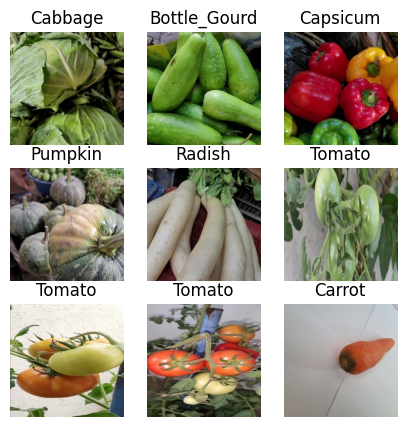

In [19]:
plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования (последние 15%)**

In [20]:
test_dataset = image_dataset_from_directory('dataset/Vegetable Images/test',
                                             shuffle=True,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 3000 files belonging to 15 classes.


In [21]:
test_dataset.class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

## Autotune
**Autotune в TensorFlow используется для автоматической настройки производительности вашего конвейера ввода данных с помощью предварительной выборки данных. Предварительная выборка означает, что пока текущий пакет данных обрабатывается вашей моделью на GPU, следующий пакет данных подготавливается на CPU параллельно. Это помогает максимизировать использование GPU и минимизировать время простоя, что приводит к более быстрой тренировке моделей.**

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Подробное объяснение Autotune
1. Предварительная выборка данных:
 - Предварительная выборка включает загрузку данных заранее до того, как они понадобятся для вычислений. Это уменьшает время, которое модель тратит на ожидание готовности данных, и позволяет GPU постоянно получать данные, улучшая общую пропускную способность.

2. AUTOTUNE:
 - AUTOTUNE - это константа, предоставляемая TensorFlow, которая позволяет библиотеке динамически регулировать количество предварительно выбираемых пакетов на основе доступных системных ресурсов и рабочей нагрузки. Он автоматически находит оптимальное количество пакетов для предварительной выборки, чтобы поддерживать работу GPU без исчерпания памяти.

3. Как это работает:
 - Когда вы используете prefetch(buffer_size=AUTOTUNE), TensorFlow контролирует время, затрачиваемое на загрузку данных и обучение модели. Затем он регулирует размер буфера для предварительной выборки пакетов соответственно, чтобы конвейер данных не стал узким местом.

4. Преимущества:
 - Увеличенная пропускная способность: Путем параллельной загрузки данных и выполнения модели GPU может постоянно работать, что увеличивает общую пропускную способность.
 - Сниженная задержка: Предварительная выборка снижает задержку между пакетами, обеспечивая непрерывное обучение модели без ненужных задержек.
 - Динамическая настройка: AUTOTUNE автоматически подстраивается под производительность системы, что делает его адаптируемым к различным аппаратным конфигурациям и рабочим нагрузкам.**

## Инициализация модели ResNet50
**Используем предобученную модель ResNet50 в качестве основы для построения новой нейронной сети, которая будет использоваться для классификации изображений:**

In [30]:
resnet50_net = ResNet50(weights='imagenet',
                              include_top=False,
                              input_shape=(224, 224, 3))

- weights='imagenet': Используются предварительно обученные веса на наборе данных ImageNet. Это позволяет воспользоваться знаниями, накопленными моделью при обучении на большом и разнообразном наборе изображений.
- include_top=False: Исключает последний полностью связанный слой, предназначенный для классификации 1000 классов ImageNet. Это нужно, чтобы можно было настроить модель для собственной задачи классификации.
- input_shape=(224, 224, 3): Устанавливает форму входных изображений (224x224 пикселя с 3 каналами, RGB).

### Замораживание слоев модели ResNet50

In [31]:
resnet50_net.trainable = False

- trainable=False: Замораживает веса всех слоев модели ResNet50. Это означает, что веса этих слоев не будут изменяться во время обучения новой модели, что позволяет использовать предобученные признаки для новой задачи.

### Создание новой модели

In [44]:
model = Sequential()
model.add(Normalization(input_shape=(224, 224, 3)))
model.add(resnet50_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

- Sequential(): Создает последовательную модель, что означает, что слои будут добавляться один за другим.
- Normalization(): Добавляет слой нормализации данных, который помогает улучшить сходимость модели, нормализуя входные данные. Этот слой нормализации будет применять нормализацию к входным данным с указанной формой (224, 224, 3), что означает, что ожидаются цветные изображения размером 224x224 пикселей (224 - высота и ширина изображения, 3 - количество цветовых каналов RGB).
- model.add(resnet50_net) Добавляет всю модель ResNet50 (без верхнего уровня) как один из слоев в новой модели.
- Flatten(): Преобразует многомерные выходные данные из сверточных слоев в одномерный вектор. Это необходимо для подключения плотных слоев.
- Dense(256, activation='relu'): Плотный слой с 256 нейронами и функцией активации ReLU. Этот слой добавляет нелинейности модели и увеличивает ее мощность.
- Dropout(0.5): Слой Dropout с вероятностью 0.5. Dropout помогает предотвратить переобучение, случайным образом обнуляя выходные значения некоторых нейронов во время обучения.
- Dense(15, activation='softmax'): Плотный слой с 15 нейронами (по числу классов в задаче классификации) и функцией активации Softmax. Softmax преобразует выходные значения в вероятности, которые суммируются до 1, что удобно для задач многоклассовой классификации.

**Компиляция модели**

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

- loss='sparse_categorical_crossentropy': Функция потерь для задач многоклассовой классификации с метками классов, представленных целыми числами.
- optimizer='adam': Оптимизатор Adam, который является адаптивным методом стохастической оптимизации и часто используется из-за его эффективности и хороших свойств сходимости.
- metrics=['accuracy']: Метрика для оценки производительности модели, в данном случае точность.

## Обучаем нейронную сеть

- train_dataset: Датасет, который используется для обучения модели.
- validation_data: Датасет, который используется для оценки модели на каждом шаге обучения (каждой эпохе).
- epochs=3: Количество эпох обучения (полных проходов через весь тренировочный датасет).

In [46]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=3)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 819s 7s/step - accuracy: 0.7827 - loss: 3.2446 - val_accuracy: 0.9920 - val_loss: 0.0434
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 795s 7s/step - accuracy: 0.9674 - loss: 0.1504 - val_accuracy: 0.9953 - val_loss: 0.0184
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 955s 8s/step - accuracy: 0.9757 - loss: 0.1254 - val_accuracy: 0.9963 - val_loss: 0.0196


## Оцениваем качество обучения сети

In [47]:
scores = model.evaluate(test_dataset, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.9945 - loss: 0.0230


In [48]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 99.5333


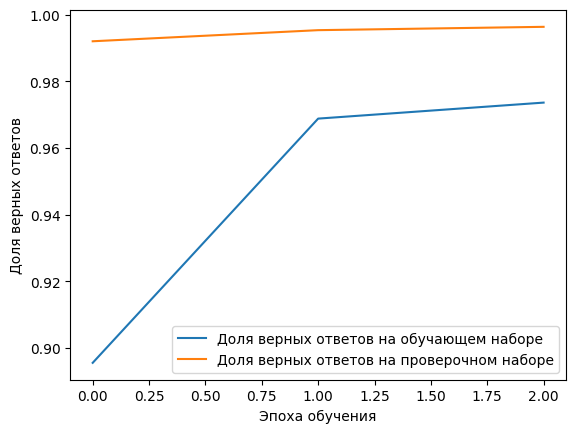

In [49]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

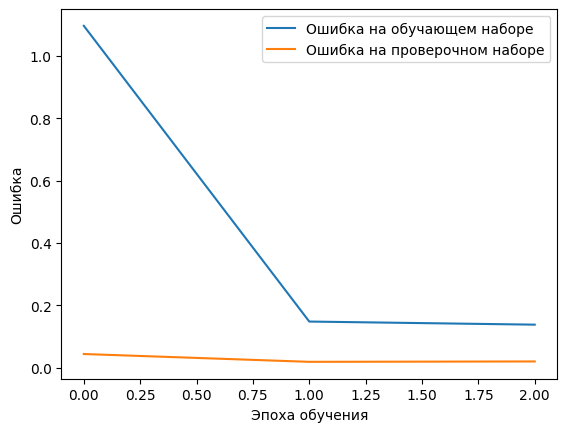

In [50]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Тонкая настройка предобученной модели ResNet50
**Тонкая настройка (fine-tuning) позволяет дообучить часть слоев предобученной модели на новых данных, что может улучшить производительность модели на специфических задачах**

### 1. Разрешение обучения части слоев ResNet50

In [51]:
resnet50_net.trainable = True
trainable = False
for layer in resnet50_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

- resnet50_net.trainable = True: Сначала мы разрешаем обучение всех слоев модели ResNet50.
- trainable = False: Создаем флаг trainable и устанавливаем его в False.
- for layer in resnet50_net.layers: Проходимся по всем слоям модели ResNet50.
    - if layer.name == 'block5_conv1': Проверяем, является ли имя слоя 'block5_conv1'. Это первый сверточный слой в пятом блоке ResNet50.
    - trainable = True: Если находим этот слой, устанавливаем флаг trainable в True, начиная с этого слоя и дальше, все слои будут обучаемыми.
    - layer.trainable = trainable: Устанавливаем атрибут trainable слоя в значение флага trainable.

**Таким образом, до слоя 'block5_conv1' все слои остаются замороженными (не обучаемыми), а начиная с 'block5_conv1' и далее, все слои становятся обучаемыми.**

### 2. Компиляция модели

In [52]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(1e-5),
              metrics=['accuracy'])

- loss='sparse_categorical_crossentropy': Функция потерь для задач многоклассовой классификации.
- optimizer=Adam(1e-5): Оптимизатор Adam с очень маленьким шагом обучения (1e-5). Маленький шаг обучения используется, чтобы не разрушить предобученные веса, а лишь немного их скорректировать.
- metrics=['accuracy']: Метрика для оценки производительности модели, в данном случае точность.

### 3. Обучение модели

In [53]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=3)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 852s 7s/step - accuracy: 0.9808 - loss: 0.1177 - val_accuracy: 0.9977 - val_loss: 0.0145
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 867s 7s/step - accuracy: 0.9869 - loss: 0.0745 - val_accuracy: 0.9977 - val_loss: 0.0109
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 869s 7s/step - accuracy: 0.9879 - loss: 0.0548 - val_accuracy: 0.9980 - val_loss: 0.0085


## Оцениваем качетсво обучения сети

In [54]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.9981 - loss: 0.0060


In [55]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 99.8333


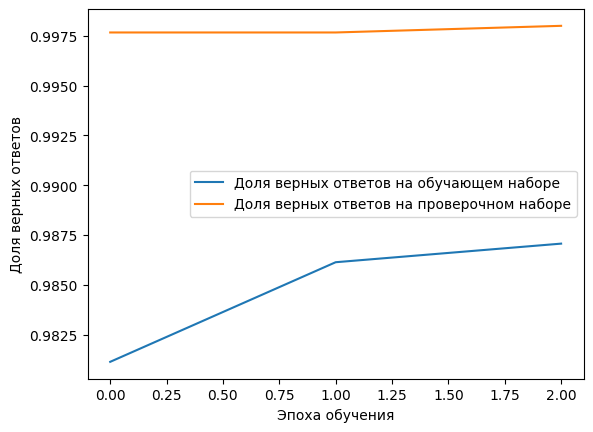

In [56]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("model/vegetable_classifier.keras")

## Проверим обученную нейронную сеть

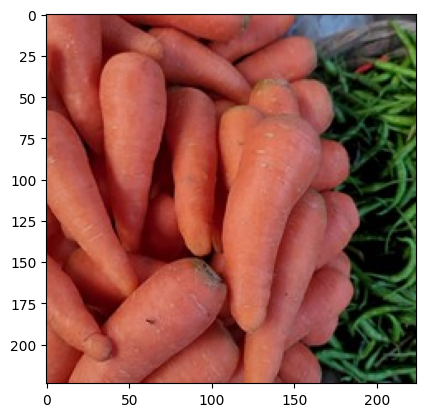

In [9]:
model = tf.keras.models.load_model('model/vegetable_classifier.keras')
filename = 'dataset/Vegetable Images/test/Carrot/1002.jpg'
img = image.load_img(filename, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [12]:
# Предобработка изображения
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [13]:
# Предсказание класса
prediction = model.predict(img_array)
print(prediction)
a = (max(prediction))
b = class_names
print(b[np.argmax(a)])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[[9.6944249e-27 0.0000000e+00 8.3512723e-30 0.0000000e+00 5.0468954e-25
  0.0000000e+00 3.8292353e-26 1.0000000e+00 7.7869037e-25 2.4436175e-28
  4.5627924e-34 0.0000000e+00 0.0000000e+00 3.8596474e-20 0.0000000e+00]]
Carrot


# Трансферное обучение (Transfer Learning)
**Трансферное обучение заключается в использовании предобученной модели для выполнения новой задачи. Это достигается за счет переноса знаний, накопленных моделью при обучении на большом и разнообразном наборе данных (например, ImageNet), к новой задаче, где может быть ограниченное количество данных для обучения.**

**Трансферное обучение обычно применяется для задач, где ваш набор данных слишком мал для полноценного обучения модели с нуля.**

**Наиболее распространенная форма трансферного обучения в контексте глубокого обучения включает следующий рабочий процесс:**

1. Возьмите слои из предобученной модели. (в нашем случае ResNet50)
2. Заморозьте их, чтобы избежать разрушения информации, которую они содержат, в ходе последующих этапов обучения.
3. Добавьте несколько новых, обучаемых слоев поверх замороженных слоев. Они научатся преобразовывать старые признаки в предсказания на новом наборе данных.
4. Обучите новые слои на вашем наборе данных.
5. Последний, необязательный шаг — это тонкая настройка (Fine tuning), которая заключается в размораживании всей модели (или ее части) и повторном обучении на новых данных с очень низкой скоростью обучения. Это может привести к значительным улучшениям, постепенно адаптируя предобученные признаки к новым данным.

## Fine Tuning
Тонкая настройка
После того как ваша модель достигла сходимости на новых данных, вы можете попытаться разморозить всю базовую модель или ее часть и переобучить всю модель от начала до конца с очень низкой скоростью обучения.

Это необязательный последний шаг, который может потенциально дать вам постепенные улучшения. Он также может привести к быстрому переобучению – имейте это в виду.

Важно выполнять этот шаг только после того, как модель с замороженными слоями была обучена до сходимости. Если вы смешаете случайно инициализированные обучаемые слои с обучаемыми слоями, содержащими предобученные признаки, то случайно инициализированные слои вызовут очень большие обновления градиентов во время обучения, что разрушит ваши предобученные признаки.

Также важно использовать очень низкую скорость обучения на этом этапе, потому что вы обучаете гораздо более большую модель, чем в первом этапе обучения, на наборе данных, который обычно очень мал. В результате, вы рискуете быстро переобучиться, если будете применять большие обновления весов. Здесь вы хотите лишь постепенно адаптировать предобученные веса.

## Feature Extraction (Извлечение признаков) vs. Freezing layers (Замораживание слоев)

**Feature Extraction:**
- Вы используете предобученную модель для извлечения признаков из нового набора данных. Эти признаки затем используются для обучения новой, меньшей модели. В этом случае предобученная модель выполняется один раз, и выходные данные одного или нескольких слоев используются как входные данные для новой модели.

**Freezing Layers:**
- Вы используете предобученную модель как основу и добавляете новые слои для выполнения специфической задачи. Все слои базовой модели замораживаются (их веса не изменяются), чтобы сохранить предобученные признаки, и только новые слои обучаются на новых данных.

**В нашем случае мы используем Freezing Layers**

### Преимущества трансферного обучения
- Экономия времени и ресурсов: Предобученные модели обучены на больших наборах данных, что экономит значительное количество времени и вычислительных ресурсов.
- Улучшение производительности: Использование предобученных моделей часто улучшает производительность, особенно при наличии ограниченного количества данных для новой задачи.
- Быстрая адаптация: Модель может быстро адаптироваться к новой задаче, используя уже накопленные знания.

**Таким образом, наш код является примером трансферного обучения, сочетающего извлечение признаков и тонкую настройку для создания мощной и адаптированной модели.**

[Гайд от Keras по Transfer learning & fine tuning](https://keras.io/guides/transfer_learning/)